# Embedding

## **Initial embedding**   
- 단어 => 숫자 벡터(**`One-hot vector`**)로 변환 하는 단계
  - 모든 단어를 고유한 정수 ID로 매핑
  - 상응하는 ID의 위치만 1이고, 나머지는 0인 벡터

<br>

## **One-hot vector**   

|단어	|ID	|One-hot vector (vocab_size = 5)|
|:---|:---|:---|
|apple|	0|	[1, 0, 0, 0, 0]|
|banana|	1|	[0, 1, 0, 0, 0]|
|cat|	2|	[0, 0, 1, 0, 0]|

👉🏻 ID에 상응하는 index위치에 상응하는 값만 1인 것을 볼 수 있다   

- 단어 간 의미를 담지 못한다
- 따라서 아래와 같은 추가적인 프로세스를 거쳐 의미(의미 관계)를 부여한다

|구조|	역할|
|:---|:---|
|✅ Embedding Layer|	단어에 기초적인 의미 기반 벡터를 부여 (학습 가능)|
|✅ Self-Attention |(Q, K, V)	문맥 기반 의미를 추가로 파악함 (각 단어가 주변 단어에 주의를 얼마나 기울일지 계산)|

<br>

## **Embedding Layer**   
``` python
nn.Embedding(vacab_size, embedding_dim)
```   
- 각 단어 ID를 의미 있는 벡터로 변환
- input
  - initial embedding을 통해 출력된 output(정수 ID 토큰)
- output
  - 학습 가능한 dense vector(Transformer의 입력 값 = 단어의 의미를 밀집하게 압축해놓은 벡터)
    ``` python
    # 만약 apple, banana, cat에 대한 one-hot vector가 아래처럼 들어오면
    token_ids = [0, 1, 2]
    # => [apple, banana, cat]
    
    embedding = nn.Embedding(5, 4)  # vocab 5개, embedding 차원 4
    # 출력: shape (3, 4)짜리 벡터 (각 단어마다 하나씩)
    # apple   1행   
    # banana  2행   * embedding dimension 4
    # cat     3행   
    ```

### Dense vector
- Transformer 모델에 들어가는 단어 표현
- **숫자들로 구성된 고차원 벡터**
  - **단어의 의미를 압축**해 놓은 숫자 배열

ex> `nn.Embedding(vocab_size=30_000, embedding_dim=8)`
``` python
# ex>
embedding = nn.Embedding(30000, 8)

pizza_vector = embedding(torch.LongTensor([12345]))  # shape: (1, 8)
print(pizza_vector)
# => tensor([[ 0.12, -0.87,  0.45,  0.01, -0.33,  0.77,  0.10, -0.56]])
# => pizza의 dense vector
```
- 학습 전에는 위 처럼 랜덤 값이지만, 학습을 거치면서 의미를 갖게 된


<br>

## **Word Embedding Process**

```
텍스트 → 토큰화(tokenize) → 토큰 ID → nn.Embedding → 의미 벡터 (input embedding)
```
example

``` python
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
input_ids = tokenizer("I love pizza")["input_ids"]
# => [101, 1045, 2293, 10733, 102]: BERT tokenizer로 text 토큰화하여 나온 정수 ID

# Embedding layer
embedding = nn.Embedding(30522, 768)  # BERT vocab_size, hidden size
# => 5 * 768 텐서

embedded_input = embedding(torch.LongTensor(input_ids))
# embedded_input shape: (5, 768)
```

<br>

## **유사 단어 => 유사 Embedding vector?**   
- Model은 학습 과정에서 embedding을 loss를 줄이는 방향으로 자동 조정한다
  - 그 과정에서 loss를 줄이는 방향으로 가는 비슷한 목적을 가진 단어들이 생겨난다
  - 이 단어들을 유사 단어라고 판단한다
  - backpropagation을 통해 해당 유사 단어들은 비슷한 벡터가 되어야겠다 판단하고, embedding weight을 조정한다
    - **학습 과정에서 의미가 부여된 embedding**

- 간단히
  - 유사 위치에서 자주 등장
  - 유사 문맥에 같이 존재
  - 손실을 줄이는 방향의 비슷한 목적
  => **embedding vector또한 비슷해짐**

In [2]:
import torch

### 가상의 단어 ID를 넣어 dense vector를 추출하는 과정

In [5]:
embedding = torch.nn.Embedding(10, 5) # vocab_size=10, embedding_dim=5
input_ids = torch.LongTensor([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]])

dense_vector = embedding(input_ids)

print(dense_vector.shape)
print(dense_vector) # 10 * 5 vector

torch.Size([1, 10, 5])
tensor([[[-0.4722,  0.0334, -0.5206, -2.3390,  0.7291],
         [ 0.6511, -0.8099,  0.5634,  1.0723, -0.4318],
         [ 1.2298, -0.0332, -0.5408, -0.7252,  0.9107],
         [ 1.1280, -0.8930, -0.1105, -0.3624, -1.8380],
         [-2.7043, -0.2312,  0.2045,  0.0582,  0.3967],
         [-0.8955,  0.1320, -0.8045, -0.1394,  0.3813],
         [-0.2275, -0.3570, -1.4809,  0.7554, -0.3038],
         [ 1.6199, -0.5144, -2.2294,  0.2658, -1.2197],
         [-0.0930, -1.0166, -1.1938,  0.0672,  0.1143],
         [-0.2430, -1.7458,  1.4125,  0.7822,  1.5839]]],
       grad_fn=<EmbeddingBackward0>)


# Embedding 실습

In [7]:
from transformers import BertTokenizerFast, BertModel

In [8]:
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")
model.eval()

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

### 토큰 ID 얻기

In [23]:
text= ['I like car', 'we like to eat burger', 'it is a bear']

tokens = tokenizer(text, return_tensors='pt', padding=True, truncation=True)

print(tokens['input_ids'])
print(tokens['attention_mask'])

tensor([[  101,  1045,  2066,  2482,   102,     0,     0],
        [  101,  2057,  2066,  2000,  4521, 15890,   102],
        [  101,  2009,  2003,  1037,  4562,   102,     0]])
tensor([[1, 1, 1, 1, 1, 0, 0],
        [1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0]])


### BERT 첫 번째 레이어

In [24]:
with torch.no_grad():
    output = model(**tokens)
    embeddings = output.last_hidden_state[:, 0, :] # CLS 토큰 벡터 사용
    # dense vector
    print(embeddings)

tensor([[ 0.0612,  0.1757, -0.0554,  ..., -0.0099,  0.1809,  0.0485],
        [ 0.3826, -0.0089, -0.1459,  ..., -0.0822,  0.3353,  0.1117],
        [-0.3451,  0.3014, -0.2131,  ..., -0.0187,  0.4021,  0.4371]])


### 유사도 계산 - BERT
- BERT는 기본적으로 문법적 유사성에 민감하여 3문장에 대해 유사도를 높게 측정함
- cosine_similarity는 벡터의 방향만 비교하기 때문에, **벡터 간 의미 차이나 문맥의 중요성은 반영하지 못한다**
- 현재 BERT는 pretained만 된 fine tuning되지 않은 상태라 일반적인 문장 구분이 약한 상태

**유사도를 좀 더 명확하게 하고 싶다면**   

|방법|	설명|
|:---|:---|
|🔧 Fine-tuned BERT|	감정 분류나 문장 분류 태스크에 훈련된 모델 사용
|📈 Mean Pooling|	[CLS] 토큰 대신 모든 토큰 임베딩 평균을 써보는 방식
|🎯 더 긴 문장|	더 많은 문맥 정보 → BERT가 차이를 잘 파악할 수 있음
|🧬 Siamese BERT / Sentence-BERT|	문장 간 유사도에 특화된 BERT (SBERT) → cosine similarity가 훨씬 잘 작동


In [27]:
sim_01 = torch.nn.functional.cosine_similarity(embeddings[0], embeddings[1], dim=0)
sim_02 = torch.nn.functional.cosine_similarity(embeddings[0], embeddings[2], dim=0)
sim_12 = torch.nn.functional.cosine_similarity(embeddings[1], embeddings[2], dim=0)

print(f"🧩 'I like car' vs 'we like to eat burger': {sim_01.item():.4f}")
print(f"🧩 'I like car' vs 'it is a bear': {sim_02.item():.4f}")
print(f"🧩 'we like to eat burger' vs 'it is a bear': {sim_12.item():.4f}")

🧩 'I like car' vs 'we like to eat burger': 0.9461
🧩 'I like car' vs 'it is a bear': 0.9262
🧩 'we like to eat burger' vs 'it is a bear': 0.9223


### 유사도 계산 - SBERT
- 문장 간 의미 유사도에 맞춰 학습된 모델
- 문장 유사도, 검색, 의미 기반 클러스터링 등에 사용한다

In [28]:
from sentence_transformers import SentenceTransformer, util

In [31]:
model_sbert = SentenceTransformer('all-MiniLM-L6-v2')
embeddings_sbert = model_sbert.encode(text, convert_to_tensor=True)

sim_sbert_01 = util.cos_sim(embeddings_sbert[0], embeddings_sbert[1])
sim_sbert_02 = util.cos_sim(embeddings_sbert[0], embeddings_sbert[2])
sim_sbert_12 = util.cos_sim(embeddings_sbert[1], embeddings_sbert[2])

`I like car` ↔ `we like to eat burger`
→ **like + something** 구조로 감성 표현 + 대상 포함 → 유사도 가장 높음 ✅

`I like car` ↔ `it is a bear`
→ 구조는 비슷하지만 **주제나 감정 표현이 다름** → 낮은 유사도

`we like to eat burger` ↔ `it is a bear`
→ 가장 동떨어진 문맥 → 가장 낮은 유사도 👍

In [32]:
print(f"🧩 'I like car' vs 'we like to eat burger': {sim_sbert_01.item():.4f}")
print(f"🧩 'I like car' vs 'it is a bear': {sim_sbert_02.item():.4f}")
print(f"🧩 'we like to eat burger' vs 'it is a bear': {sim_sbert_12.item():.4f}")

🧩 'I like car' vs 'we like to eat burger': 0.3628
🧩 'I like car' vs 'it is a bear': 0.1283
🧩 'we like to eat burger' vs 'it is a bear': 0.0742


### BERT / SBERT 유사도 시각화 - t-SNE
- 간단히 이런게 있다 정도로 넘어간다

In [45]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

perplexity 값이 text의 index 수보다 많으면 안된다

In [40]:
tsne_sbert = TSNE(n_components=2, random_state=42, perplexity=2)
tsne = TSNE(n_components=2, random_state=42, perplexity=2)
reduced_sbert = tsne_sbert.fit_transform(embeddings_sbert)  #SBERT
reduced = tsne.fit_transform(embeddings)              #BERT

**시각화**   
- SBERT: 의미 위주로 학습되어 군집이 모여있다
- BERT: 상대적으로 산개되어있는 것을 확인할 수 있다

**점과 점 사이의 거리가 유사도를 나타낸다**

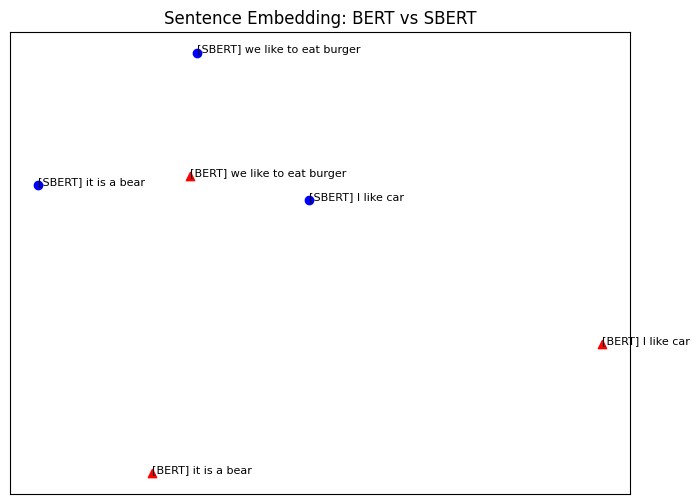

In [55]:
plt.figure(figsize=(8, 6))
#BERT
for i, (x, y) in enumerate(reduced):
    plt.scatter(x, y, color='red', marker='^', label='BERT' if i == 0 else "")
    plt.text(x + 0.01, y + 0.01, f'[BERT] {text[i]}', fontsize=8)
#SBERT
for i, (x, y) in enumerate(reduced_sbert):
    plt.scatter(x, y, color='blue', marker='o', label='SBERT' if i == 0 else "")
    plt.text(x + 0.01, y + 0.01, f'[SBERT] {text[i]}', fontsize=8)

#BERT
plt.title("Sentence Embedding: BERT vs SBERT")
plt.xticks([])
plt.yticks([])
plt.show()